In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [2]:
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
import matplotlib

dpe = DPE('COM6')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Load various data
--

In [3]:
# Load the offline trained weights
# And the MNIST dataset
load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

# Load the target conductane for linear correction
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


Neural network model
--
Set the binarzation bits

In [4]:
nn = NN_dpe(weights)
dpe.N_BIT = 8

In [5]:
img_idx = 1

image = test_images[img_idx]
vectors = nn._conv_flattern(image)

# normalize
vectors /= np.abs(vectors).max()

ts = time.time()
output = dpe.multiply(1, vectors, c_sel=[0, 14], mode=0, Tdly=0) / (nn.Gratio/2)
print(time.time()-ts)
soft_output = (finalGconv.T @ vectors).T / (nn.Gratio/2)

1.7546277046203613


In [6]:
lin_cor_conv = []
for c in range(14):
    lin_cor_conv.append( np.polyfit(output[:,c], soft_output[:,c], 1))

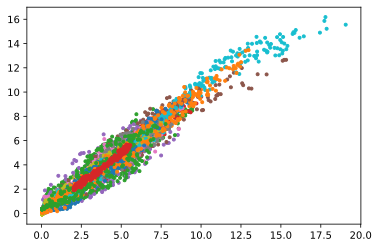

In [7]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

for c in range(14):
    x = soft_output[:,c]
    y = output_cor[:,c]
    
    plt.plot(x,y,'.')
    
x = output_cor[:,::2] - output_cor[:,1::2]

x = x.reshape(20,20,-1)

# plt.imshow(x[:,:,2])
# plt.colorbar()

Software fully connected layer
--

In [8]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y)
print(y.argmax())

[-13.44316915 -16.68391449  -3.40962334  -9.38185108 -26.50843652
 -19.11872552  -5.20051573 -36.64659892  -2.20645166 -33.37069388]
8


Accuracy test (experimental convolution)
--


In [ ]:
acc = []
i = 0

for label, img in zip(test_labels, test_images):
    
    vectors = nn._conv_flattern(img)
    
    # Convolution hardware call
    output = dpe.multiply(1, vectors, c_sel=[0, 14], mode=0) / (nn.Gratio/2)
    output_cor = dpe.lin_corr(output, lin_cor_conv)
    x = output_cor[:,::2] - output_cor[:,1::2]

    x = x.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    # Software fully connect
    y = nn.dense(x1)
    
    acc.append( y.argmax() == label)
    
    display.clear_output(wait=True)
    
    # Plot
    fig = plt.figure(1)
    for ii in range(7):
        plt.subplot('33' + str(ii+1))
        plt.title('Channel #' + str(ii))
        plt.imshow(x[:,:,ii])
#         plt.colorbar()
    plt.tight_layout()
    display.display(fig)
    
    
    print(f'idx={i}, predicted: {y.argmax()}, label: {test_labels[i]}')
    acc.append( y.argmax() == test_labels[i] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
    i += 1


For hardware dense (fully connect) layer, refer to 'testbench_wk5_4_prober2_unary' notebook
--

Running <function DPE.read at 0x0FE04618> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected


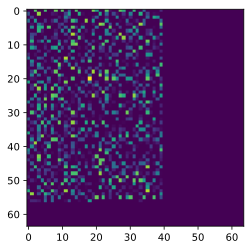

In [15]:
plt.imshow(dpe.read(0))

In [9]:
# Load the target conductane for linear correction
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']
nn = NN_dpe(weights)
dpe.N_BIT = 8

load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)
np.shape(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


(10000, 112)

In [10]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGfc.mat')
finalGfc = mat_contents['finalGfc']

x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = finalGfc[:57]
Gfc2 = finalGfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

dpe.N_BIT = 8

output1 = dpe.multiply(0, x1, c_sel=[0, 20], mode=0, Tdly=0)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(0, x2, c_sel=[20, 40], mode=0, Tdly=0)
software2 = (Gfc2.T @ x2).T

In [11]:
new_lin_cor_fc1 = []
new_lin_cor_fc2 = []
for c in range(20):
    new_lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    new_lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

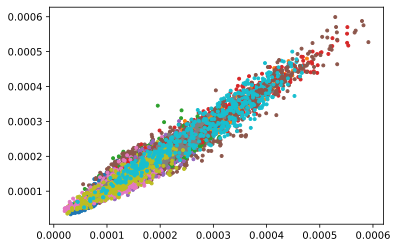

In [12]:
output_corr = dpe.lin_corr(output2, new_lin_cor_fc2)
software = (Gfc2.T @ x2).T 

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
#     plt.figure(c)
    plt.plot(x,y,'.')

In [14]:
ys = []
batch_size = 100

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(0, x1, c_sel=[0, 20], mode=0, Tdly=0)
    output1 = dpe.lin_corr(output1, new_lin_cor_fc1) * sc1

    output2  = dpe.multiply(0, x2, c_sel=[20, 40], mode=0, Tdly=0)
    output2 = dpe.lin_corr(output2, new_lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Total accuracy = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Accuracy = 95.00%
Total accuracy = 92.33%
Running on sample 1200-1300


KeyboardInterrupt: 

In [22]:
dpe.set_clock(50)

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


In [23]:
save_workspace(vars(), filename='demo')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), ts(<class 'float'>), output(<class 'numpy.ndarray'>), soft_output(<class 'numpy.ndarray'>), lin_cor_conv(<class 'list'>), c(<class 'int'>), output_cor(<class 'numpy.ndarray'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), finalGfc(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>

## GUI

In [16]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from PIL import Image 

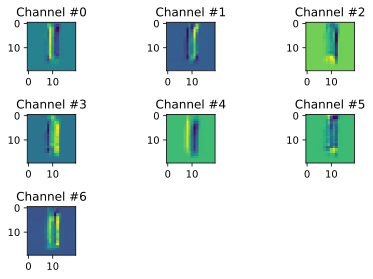

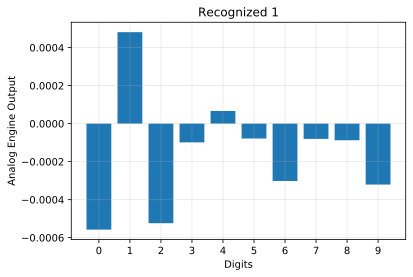

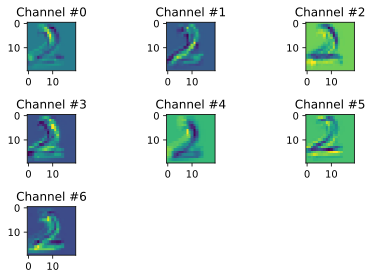

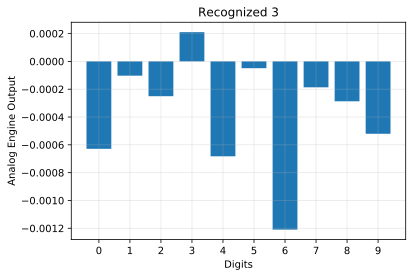

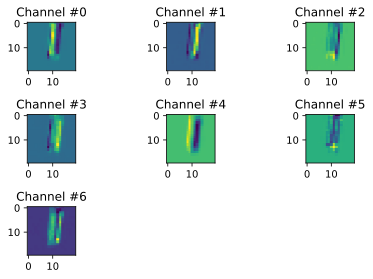

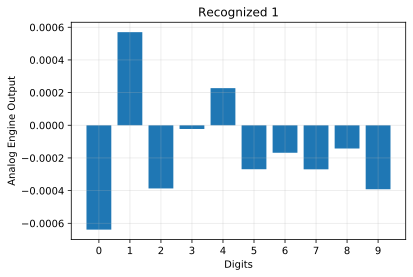

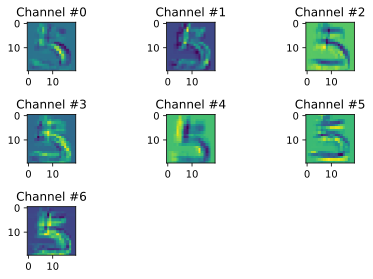

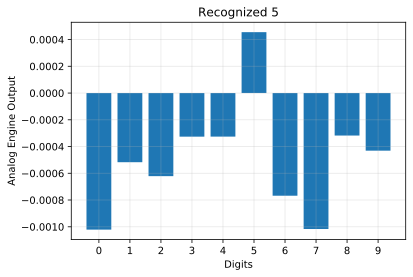

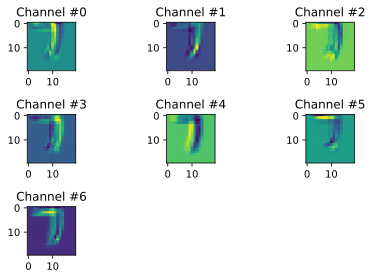

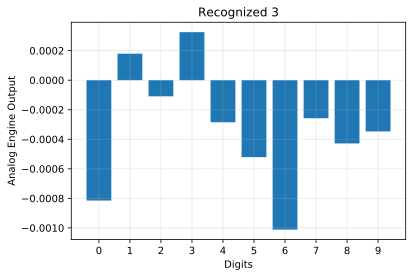

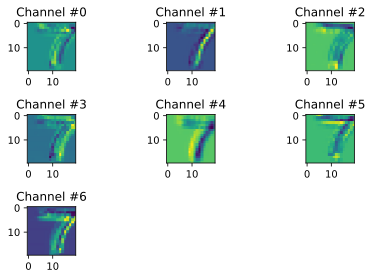

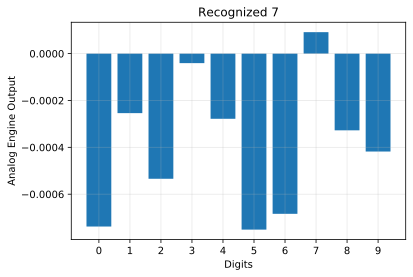

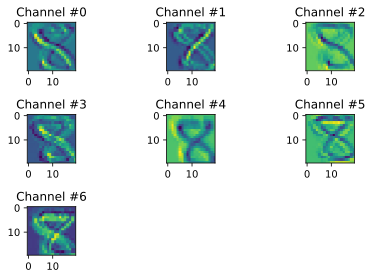

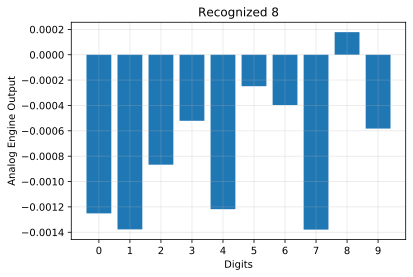

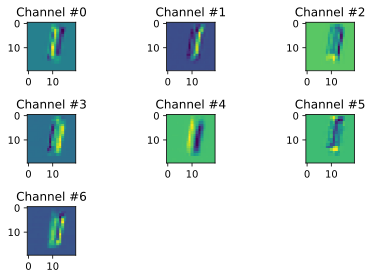

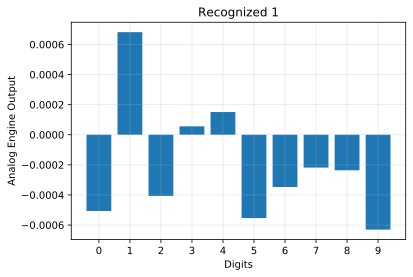

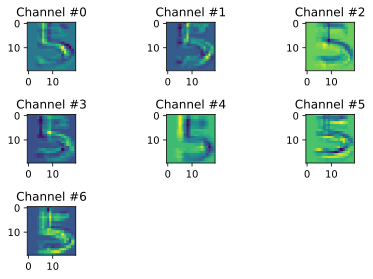

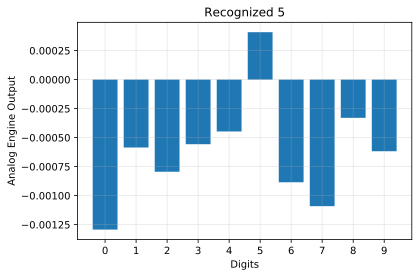

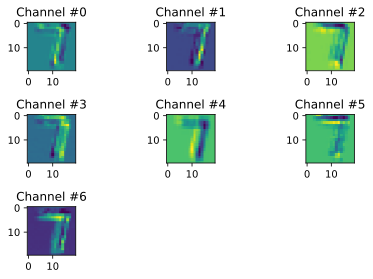

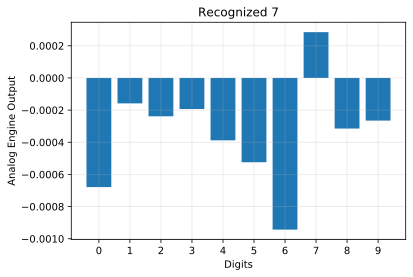

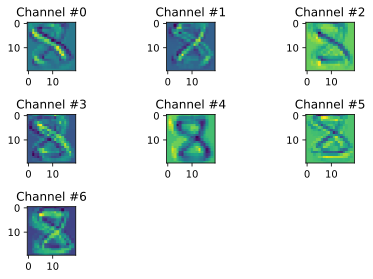

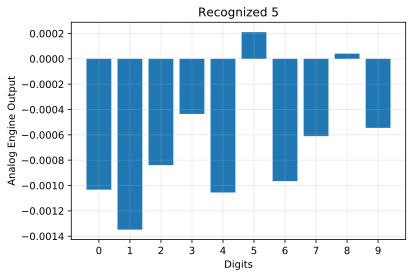

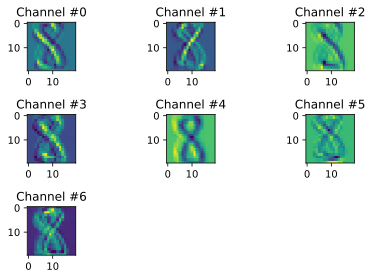

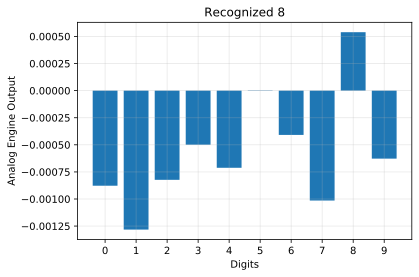

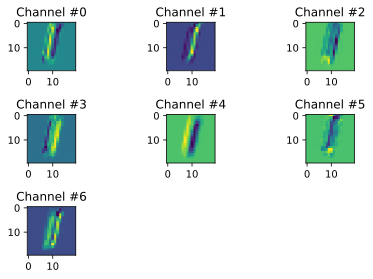

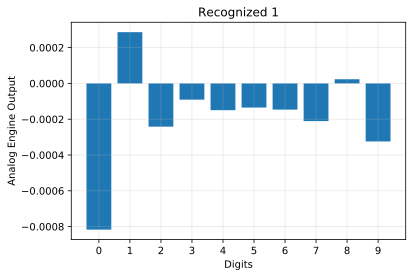

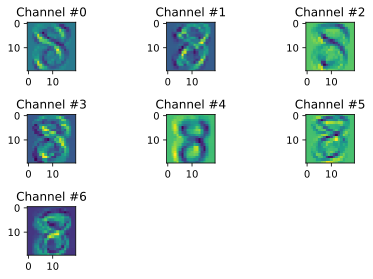

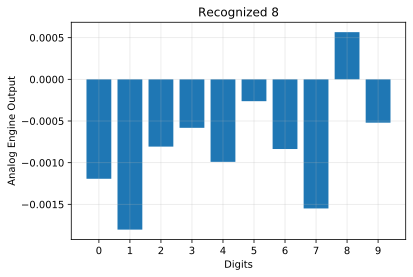

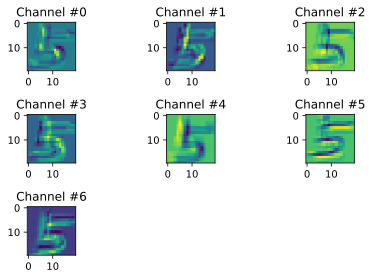

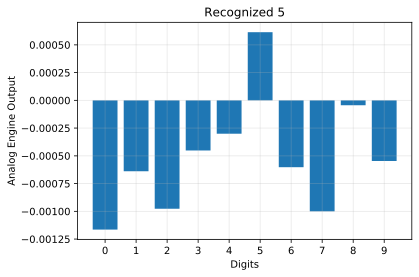

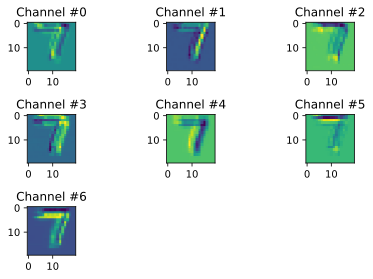

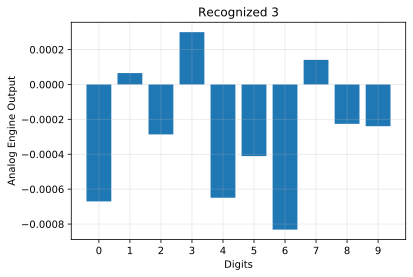

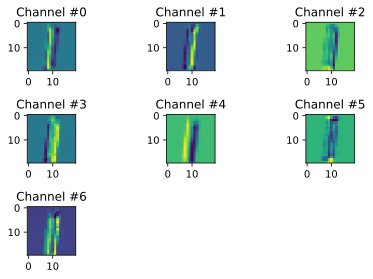

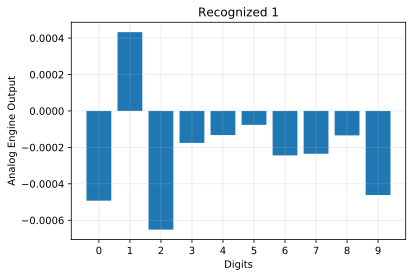

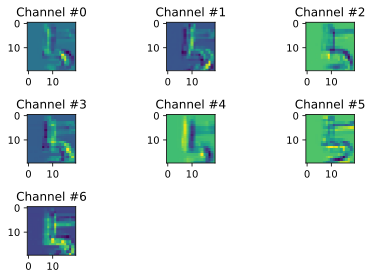

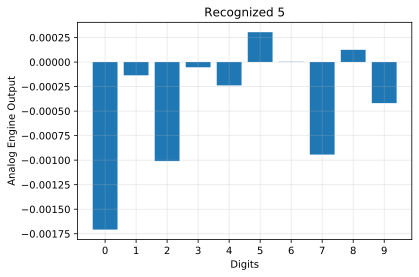

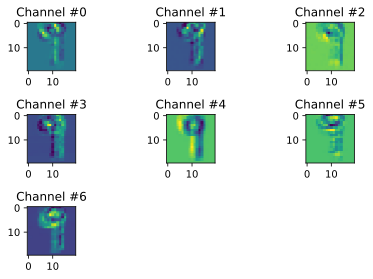

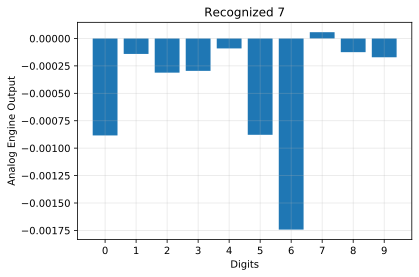

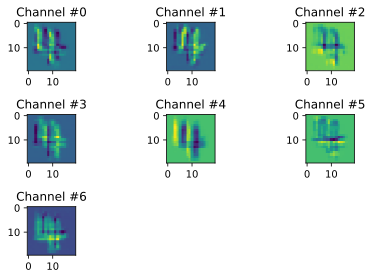

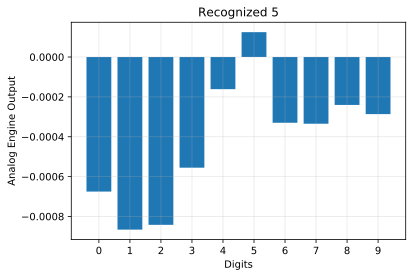

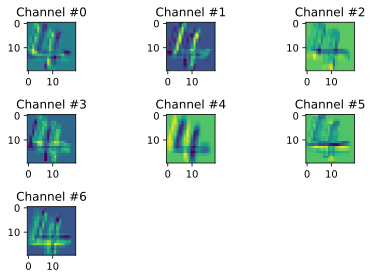

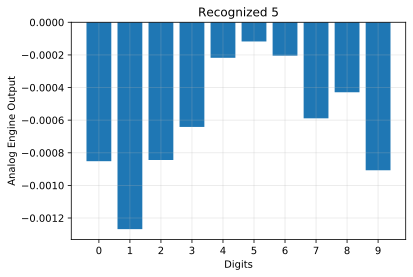

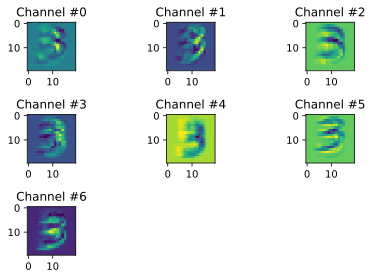

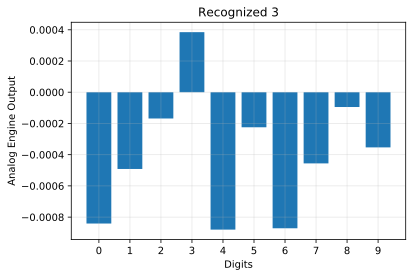

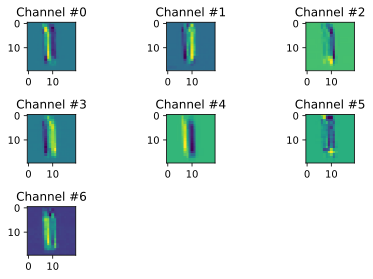

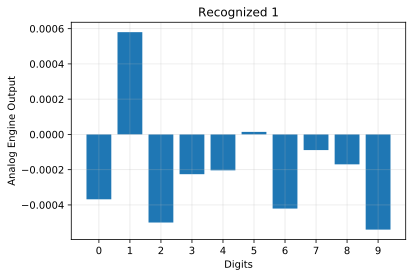

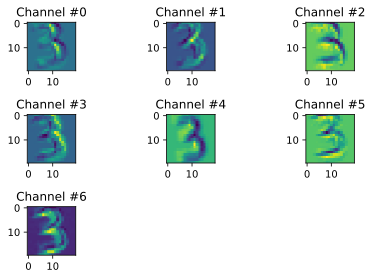

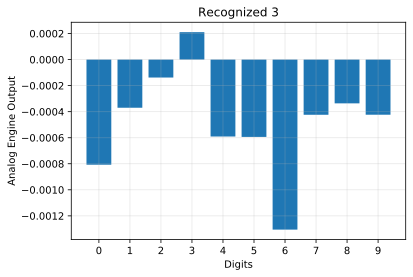

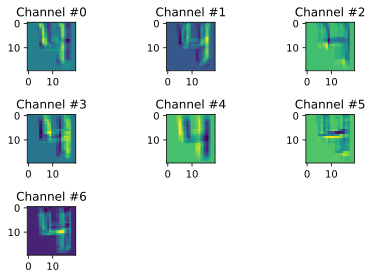

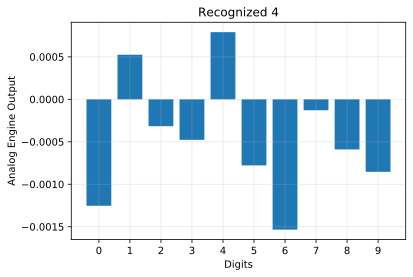

In [27]:
width = 200
height = 200
center = height//2
white = (255, 255, 255)
green = (0,128,0)

def classify():
    filename = "image.png"
    image1.save(filename)
    img = Image.open(filename)
    #userImage = np.array( img, dtype='uint8' )
    smallImg = Image.open(filename).resize((24,24), Image.ANTIALIAS)
    #userImage = np.array(Image.open(filename).convert('L'))
    userImage = np.array(smallImg.convert('L'))
    mxPixel = np.max(userImage)
    mnPixel = np.min(userImage)
    userImage = 1-((userImage-mnPixel)/(mxPixel-mnPixel))
    newImage = np.zeros((24,24,1))
    newImage[:,:,0] = userImage
    
    #NOW PERFORM THE MNIST CLASSIFICATION
    vectors = nn._conv_flattern(newImage)
    
    # Convolution hardware call
    output = dpe.multiply(1, vectors, c_sel=[0, 14], mode=0) / (nn.Gratio/2)
    output_cor = dpe.lin_corr(output, lin_cor_conv)
    x = output_cor[:,::2] - output_cor[:,1::2]
    x = x.reshape(20,20,-1)
    convFilters = x    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)        
    ## Start Hardware Fully Connect
    # print(np.shape(x1))    
    x = x1    
    x1 = x[:57].T
    x2 = x[57:].T
    sc1 = x1.max()
    sc2 = x2.max()
    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]
    x1 = x1 / sc1
    x2 = x2 / sc2
    
    x1 = x1[x1 >= 0]
    x2 = x2[x2 >= 0]    
    newX1 = x1.reshape(-1,1)
    newX2 = x2.reshape(-1,1)
    #break
    output1  = dpe.multiply(0, newX1, c_sel=[0, 20], mode=0, Tdly=0)
    output1 = dpe.lin_corr(output1, new_lin_cor_fc1) * sc1

    output2  = dpe.multiply(0, newX2, c_sel=[20, 40], mode=0, Tdly=0)
    output2 = dpe.lin_corr(output2, new_lin_cor_fc2) * sc2
    outputs = output1 + output2    
    y = outputs[:,::2] - outputs[:,1::2]    
    ## End Hardware Fully Connect

    #display.clear_output(wait=True)
    classificationResult = y.argmax()
    #END CLASSIFICATION
  
    cv.create_text(5, 190, anchor=W, font="Purisa",
            text="You drew: "+str(classificationResult))
   
    # Plot
    fig = plt.figure()
    for ii in range(7):
        plt.subplot('33' + str(ii+1))
        plt.title('Channel #' + str(ii))
        plt.imshow(convFilters[:,:,ii])
    plt.tight_layout()
    display.display(fig)

    fig2 = plt.figure()
    plt.bar(np.arange(10), y[0] )
    plt.grid(True, alpha=.3)
    plt.title(f'Recognized {y.argmax()}')
    plt.xticks(np.arange(10))
    plt.xlabel('Digits')
    plt.ylabel('Analog Engine Output') 
    display.display(fig2)
    
    
def clearAll():
    draw.rectangle([0, 0, width, height], fill='white')
    cv.delete("all")
    
def paint(event):
    # python_green = "#476042"
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=7)
    draw.line([x1, y1, x2, y2],fill="black",width=7)

root = Tk()

# Tkinter create a canvas to draw on
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()

image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)

cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

button=Button(text="Classify with Analog Engine",command=classify)
button.pack()
button2=Button(text="Clear",command=clearAll)
button2.pack()
root.mainloop()